<a href="https://colab.research.google.com/github/lisatwyw/data-gym/blob/master/WISDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview #

- This is a notebook prepared for you to try out classification tasks using time-series data acquired using accelerometers of iPhone's.

- You'll get to:
 - train a model based on neural networks 
 - learn about ```CoreML```
 
- Post-demo exercise: try to replicate below using the [Actitracker dataset](http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_at_latest.tar.gz)

# A) Mount Google drive #


In [47]:
from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# B) Create subfolder ``wisdm`` in your ```opensource_datasets``` folder #

In [48]:
try:
  ! mkdir '/content/drive/My Drive/Colab Notebooks/opensource_datasets/'
except e as Exception:
  pass  
import os
try:
  ! mkdir '/content/drive/My Drive/Colab Notebooks/opensource_datasets/wisdm'
except e as Exception:
  pass  
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/opensource_datasets/wisdm')

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/opensource_datasets/’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/opensource_datasets/wisdm’: File exists


# C) Download from website and unzip contents ##

In [0]:
if os.path.isfile('wisdm.gz' )==False:
  try:
    ! wget -O wisdm.gz http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
    ! tar -xf wisdm.gz
    print('done unzipping')
  except:
    pass

  ! ls

# D) Run the following demo code written by [Nils Ackermann](https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0?)# 

In [0]:
import numpy as np
import pandas as pd

# https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0?

def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')


## Examine the data ##

In [51]:
df.head(5)

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


## Prepare the output labels ##

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing


# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel


plt.style.use('ggplot')

# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']


# The number of steps within one time segment
TIME_PERIODS = 80

# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40


# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder

le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


## Split the dataset into training and test subsets ##

In [0]:
pd.options.mode.chained_assignment = None  # default='warn'

df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]


## Normalize the input data ##

In [0]:
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [55]:
import keras
print('keras version ', keras.__version__)


keras version  2.2.5


## Prepare the training dataset ##

In [0]:
from scipy import stats
from keras.utils import np_utils


def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

# convert to float
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

# convert output labels using one-hot-encoding
y_train_hot = np_utils.to_categorical(y_train, num_classes)


In [57]:
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
print( 'Input data:', x_train.shape, '\n3 time-series and 80 timepoints; total of', y_train.shape, 'samples' )

input_shape = (num_time_periods*num_sensors)


x_train = x_train.reshape(x_train.shape[0], input_shape)

print('After reshaping, x_train has shape', x_train.shape)
print('input_shape:', input_shape)

Input data: (20868, 80, 3) 
3 time-series and 80 timepoints; total of (20868,) samples
After reshaping, x_train has shape (20868, 240)
input_shape: 240


## Construct the model ##

In [58]:
import tensorflow as tf

model_m = tf.keras.models.Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(tf.keras.layers.Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(tf.keras.layers.Dense(100, activation='relu'))
model_m.add(tf.keras.layers.Dense(100, activation='relu'))

model_m.add(tf.keras.layers.Dense(100, activation='relu'))
model_m.add(tf.keras.layers.Flatten())
model_m.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
print(model_m.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_5 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_6 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
__________________________________________________

## Train it! ##

In [59]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
42/42 [==============================] - 7s 163ms/step - loss: 1.0735 - accuracy: 0.6414 - val_loss: 0.7456 - val_accuracy: 0.8146
Epoch 2/50
42/42 [==============================] - 6s 149ms/step - loss: 0.5890 - accuracy: 0.7921 - val_loss: 0.6748 - val_accuracy: 0.8023
Epoch 3/50
42/42 [==============================] - 6s 149ms/step - loss: 0.5184 - accuracy: 0.8117 - val_loss: 0.6935 - val_accuracy: 0.7911
Epoch 4/50
42/42 [==============================] - 6s 148ms/step - loss: 0.4905 - accuracy: 0.8214 - val_loss: 0.6859 - val_accuracy: 0.7748
Epoch 5/50
42/42 [==============================] - 6s 149ms/step - loss: 0.4700 - accuracy: 0.8277 - val_loss: 0.6886 - val_accuracy: 0.7777
Epoch 6/50
42/42 [==============================] - 6s 149ms/step - loss: 0.4455 - accuracy: 0.8389 - val_loss: 0.6566 - val_accuracy: 0.8052
Epoch 7/50
42/42 [==============================] - 6s 147ms/step - loss: 0.4338 - accuracy: 0.8420 - val_loss: 0.7045 - val_accuracy: 0.7590
Epoch 

## Examine the training progress and evaluate the trained model ##

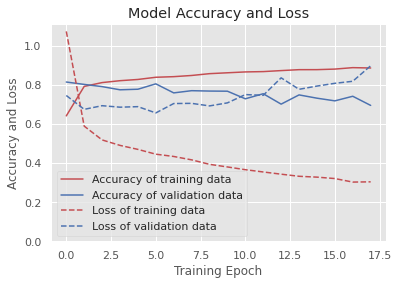

              precision    recall  f1-score   support

         0.0       0.65      0.40      0.50      1864
         1.0       0.98      0.97      0.98      6567
         2.0       0.98      0.99      0.98      1050
         3.0       0.98      0.99      0.98       833
         4.0       0.54      0.74      0.63      2342
         5.0       0.88      0.87      0.88      8212

    accuracy                           0.86     20868
   macro avg       0.84      0.83      0.82     20868
weighted avg       0.86      0.86      0.86     20868



In [60]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)


from sklearn.metrics import classification_report
print(classification_report(y_train, max_y_pred_train))


## Prepare the test subset ##

In [0]:
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels( df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
# convert to float
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

# convert output labels using one-hot-encoding
y_test_hot = np_utils.to_categorical(y_test, num_classes)


In [62]:
y_test.shape

(6584,)

## Evaluate the model on the test set and report results with a confusion matrix ##

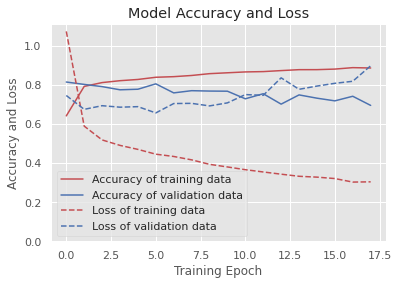

              precision    recall  f1-score   support

         0.0       0.65      0.40      0.50      1864
         1.0       0.98      0.97      0.98      6567
         2.0       0.98      0.99      0.98      1050
         3.0       0.98      0.99      0.98       833
         4.0       0.54      0.74      0.63      2342
         5.0       0.88      0.87      0.88      8212

    accuracy                           0.86     20868
   macro avg       0.84      0.83      0.82     20868
weighted avg       0.86      0.86      0.86     20868



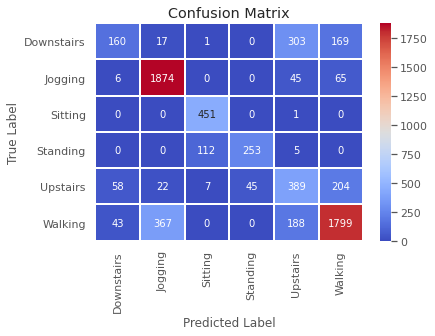

              precision    recall  f1-score   support

         0.0       0.60      0.25      0.35       650
         1.0       0.82      0.94      0.88      1990
         2.0       0.79      1.00      0.88       452
         3.0       0.85      0.68      0.76       370
         4.0       0.42      0.54      0.47       725
         5.0       0.80      0.75      0.78      2397

    accuracy                           0.75      6584
   macro avg       0.71      0.69      0.69      6584
weighted avg       0.75      0.75      0.74      6584



In [63]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)


print(classification_report(y_train, max_y_pred_train))


x_test = x_test.reshape(x_test.shape[0], input_shape)

y_pred_test = model_m.predict(x_test)

# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)


import seaborn as sns  # ! pip install seaborn
import matplotlib.pyplot as plt
from sklearn import metrics

def show_confusion_matrix(validations, predictions, LABELS ):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# y_test, max_y_pred_test are (nSamples,1), LABELS is a list of the classes, indexed from 0 up to num_classes-1
show_confusion_matrix(y_test, max_y_pred_test, LABELS )

print(classification_report(y_test, max_y_pred_test))

# E) Change some hyperparameters and examine effect of the changes #

In [64]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2) # <-- changed
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 128 # <-- changed
EPOCHS = 100  # <-- changed

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      initial_epoch=0,                      
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/100
131/131 [==============================] - 7s 55ms/step - loss: 0.3146 - accuracy: 0.8831 - val_loss: 0.7825 - val_accuracy: 0.7465
Epoch 2/100
131/131 [==============================] - 7s 53ms/step - loss: 0.2931 - accuracy: 0.8900 - val_loss: 0.8241 - val_accuracy: 0.7254
Epoch 3/100
131/131 [==============================] - 7s 53ms/step - loss: 0.2868 - accuracy: 0.8925 - val_loss: 0.9537 - val_accuracy: 0.6890
Epoch 4/100
131/131 [==============================] - 7s 54ms/step - loss: 0.2790 - accuracy: 0.8957 - val_loss: 0.9147 - val_accuracy: 0.7075
Epoch 5/100
131/131 [==============================] - 7s 57ms/step - loss: 0.2667 - accuracy: 0.8980 - val_loss: 0.8873 - val_accuracy: 0.7242
Epoch 6/100
131/131 [==============================] - 7s 53ms/step - loss: 0.2556 - accuracy: 0.9052 - val_loss: 1.0982 - val_accuracy: 0.6423
Epoch 7/100
131/131 [==============================] - 7s 53ms/step - loss: 0.2475 - accuracy: 0.9078 - val_loss: 0.8725 - val_accuracy:

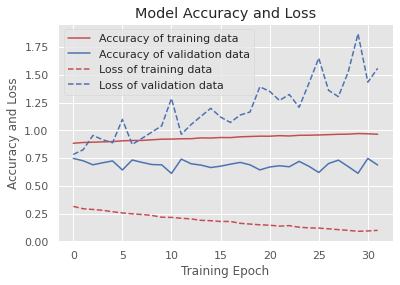

              precision    recall  f1-score   support

         0.0       0.71      0.86      0.78      1864
         1.0       0.98      0.97      0.98      6567
         2.0       1.00      1.00      1.00      1050
         3.0       1.00      1.00      1.00       833
         4.0       0.78      0.83      0.80      2342
         5.0       0.96      0.90      0.93      8212

    accuracy                           0.92     20868
   macro avg       0.90      0.93      0.91     20868
weighted avg       0.93      0.92      0.92     20868



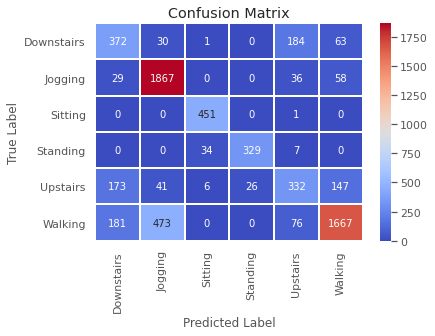

              precision    recall  f1-score   support

         0.0       0.49      0.57      0.53       650
         1.0       0.77      0.94      0.85      1990
         2.0       0.92      1.00      0.96       452
         3.0       0.93      0.89      0.91       370
         4.0       0.52      0.46      0.49       725
         5.0       0.86      0.70      0.77      2397

    accuracy                           0.76      6584
   macro avg       0.75      0.76      0.75      6584
weighted avg       0.77      0.76      0.76      6584



In [65]:
def draw_plot():
  plt.figure(figsize=(6, 4))
  plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
  plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
  plt.plot(history.history['loss'], 'r--', label='Loss of training data')
  plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
  plt.title('Model Accuracy and Loss')
  plt.ylabel('Accuracy and Loss')
  plt.xlabel('Training Epoch')
  plt.ylim(0)
  plt.legend()
  plt.show()

  # Print confusion matrix for training data
  y_pred_train = model_m.predict(x_train)
  # Take the class with the highest probability from the train predictions
  max_y_pred_train = np.argmax(y_pred_train, axis=1)

  from sklearn.metrics import classification_report
  print(classification_report(y_train, max_y_pred_train))

draw_plot()

x_test = x_test.reshape(x_test.shape[0], input_shape)

y_pred_test = model_m.predict(x_test)

# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)


import seaborn as sns  # ! pip install seaborn
import matplotlib.pyplot as plt
from sklearn import metrics

def show_confusion_matrix(validations, predictions, LABELS ):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# y_test, max_y_pred_test are (nSamples,1), LABELS is a list of the classes, indexed from 0 up to num_classes-1
show_confusion_matrix(y_test, max_y_pred_test, LABELS )

print(classification_report(y_test, max_y_pred_test))

# F) Install library ```coreML``` if not already available #

...updating to module 3.1 per suggestions on [CoreML support](https://github.com/apple/coremltools/issues/446)

In [66]:
! pip install coremltools==3.1

import coremltools

# G) Export to CoreML file #

In [0]:
coreml_model = coremltools.converters.keras.convert(model_m,
                                                    input_names=['acceleration'],
                                                    output_names=['output'],
                                                    class_labels=LABELS)
print(coreml_model)
coreml_model.author = 'Nils Ackermann'
coreml_model.license = 'N/A'
coreml_model.short_description = 'Activity based recognition based on WISDM dataset'
coreml_model.output_description['output'] = 'Probability of each activity'
coreml_model.output_description['classLabel'] = 'Labels of activity'

coreml_model.save('HARClassifier.mlmodel')